# HD firing_rate_head_direction_histogram in light and dark 

We first test on one session and then do the analysis for all sessions

In [4]:
import os
print(os.getcwd())
os.chdir('/home/kilo/repo/autopi_analysis/maryam/autopi-ca1/')
%pwd

/home/kilo/repo/autopi_analysis/maryam/autopi-ca1


'/home/kilo/repo/autopi_analysis/maryam/autopi-ca1'

In [8]:
%reload_ext autoreload
%autoreload 2
%run setup_project.py
prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList)

Project name: autopi_ca1
dataPath: /adata/projects/autopi_ca1
dlcModelPath: /adata/models
Reading /adata/projects/autopi_ca1/sessionList
We have 44 testing sessions in the list
See myProject and sSesList objects
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


# Get the HD histograms 


Now that we know how to generated the data we need, we can create functions that we can apply to all our sessions.

To simplify the stacking of the maps, we will only get one map type per function.

## Get intervals for open field, light and dark

To run get3Intervals, we need to loop over both ses and sSes.

In [24]:
def getAutoCorr(ses,sSes,binSize,minTime,maxTime):
    
    for n in sSes.cg.neuron_list:
        n.spike_train.unset_intervals()
        n.spike_train.spike_time_autocorrelation(bin_size_sec=binSize,min_sec=minTime, max_sec=maxTime)
    
    timestamp= [n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1]) for n in sSes.cg.neuron_list]
    timestampStak= np.stack(timestamp, axis=0)
    
    histoList = [n.spike_train.st_autocorrelation_histogram[0] for n in sSes.cg.neuron_list]
    histoStack = np.stack(histoList, axis=0)  
    return timestampStak,histoStack

def getMaps(ses,sSes,interName="circ80"):
    """
    Get all the maps of the data within the intervals of interest
    """
    xy_range=np.array([[-50,-90],[50,60]])
    #print("{}, number of intervals:{}".format(ses.name,len(ses.intervalDict[interName])))
    sSes.ap.set_intervals(ses.intervalDict[interName])
    for n in sSes.cg.neuron_list:
        n.spike_train.set_intervals(ses.intervalDict[interName])
        n.spatial_properties.firing_rate_map_2d(cm_per_bin =3, smoothing_sigma_cm = 3, smoothing=True,xy_range=xy_range)
    mapList = [ n.spatial_properties.firing_rate_map for n in sSes.cg.neuron_list ]
    mapStack = np.stack(mapList, axis=0)
    return mapStack

def getHDinfos(ses,sSes,interName="circ80"):
    """
    Get all the maps of the data within the intervals of interest
    """
    #print(sSes.name)
    xy_range=np.array([[-50,-90],[50,60]])
    #print("{}, number of intervals:{}".format(ses.name,len(ses.intervalDict[interName])))
    ap = Animal_pose(sSes)
    sSes.ap.unset_intervals()
    sSes.ap.set_intervals(ses.intervalDict[interName])

    for n in sSes.cg.neuron_list:
        n.spike_train.unset_intervals()
        n.spike_train.set_intervals(ses.intervalDict[interName])
        n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)
        n.spatial_properties.head_direction_score()
        
    HDhists= [n.spatial_properties.firing_rate_head_direction_histo for n in sSes.cg.neuron_list]
    HDhistsEdgs= [n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges) for n in sSes.cg.neuron_list]
    HDmeanDirDeg= [n.spatial_properties.hd_mean_direction_rad for n in sSes.cg.neuron_list]
    HDmeanVeclen= [n.spatial_properties.hd_mean_vector_length for n in sSes.cg.neuron_list]
    
    HDhistsStack= np.stack(HDhists, axis=0)
    HDhistsEdgsStack= np.stack(HDhistsEdgs, axis=0)
    HDmeanVeclenStack= np.stack(HDmeanVeclen, axis=0)
    HDmeanDirDegStack= np.stack(HDmeanDirDeg, axis=0)
    return HDhistsStack, HDhistsEdgsStack, HDmeanVeclenStack, HDmeanDirDegStack
    

## testing on a single session 


In [25]:
sSes = sSesList[0]
ses = myProject.sessionList[0]
HDhistsStack, HDhistsEdgsStack, HDmeanVeclenStack, HDmeanDirDegStack= getHDinfos(ses,sSes,interName="circ80")

/home/kilo/repo/spikeA/spikeA/Spatial_properties.py:200: RuntimeWarning: invalid value encountered in double_scalars
  self.hd_mean_vector_length = R/sum_histo


In [26]:
HDmeanVeclenStack.shape, HDmeanDirDegStack.shape, len(sSes.cg.neuron_list),  HDhistsStack.shape, HDhistsEdgsStack.shape 

((12,), (12,), 12, (12, 36), (12, 36))

## Get a summary for one sessions 

In [66]:
mapStackCirc80 = np.concatenate([getMaps(ses,sSes,"circ80") for ses,sSes in tqdm(zip(myProject.sessionList[0:1],sSesList[0:1]))])
mapStackLight = np.concatenate([getMaps(ses,sSes,"light") for ses,sSes in tqdm(zip(myProject.sessionList[0:1],sSesList[0:1]))])
mapStackDark = np.concatenate([getMaps(ses,sSes,"dark") for ses,sSes in tqdm(zip(myProject.sessionList[0:1],sSesList[0:1]))])

AutoCorr500 = np.concatenate([getAutoCorr(ses,sSes,binSize=0.0005,minTime=-0.05,maxTime=0.05) for sSes in tqdm(sSesList[0:1])])
AutoCorr50 = np.concatenate([getAutoCorr(ses,sSes,binSize=0.0025,minTime=-0.5,maxTime=0.5) for sSes in tqdm(sSesList[0:1])])


1it [00:00,  8.40it/s]
1it [00:00,  1.21it/s]
1it [00:00,  1.23it/s]
100%|██████████| 1/1 [00:00<00:00, 19.20it/s]


In [28]:
sSes = sSesList[0]
ses = myProject.sessionList[0]
get3Intervals(ses,sSes)

l=['circ80','light','dark','last_rest']
hd_Stack={}
map_Stack={}
for cond in l:
    hd_Stack[cond]=  [getHDinfos(ses,sSes, interName=cond) for ses,sSes in tqdm(zip(myProject.sessionList[0:1],sSesList[0:1]))]
    map_Stack[cond]= [getMaps(ses,sSes,interName=cond) for ses,sSes in tqdm(zip(myProject.sessionList[0:1],sSesList[0:1]))]


mn5824-20112020-0107, number of intervals:1 77 73 1


1it [00:00,  7.82it/s]
1it [00:00,  8.78it/s]
1it [00:00,  1.27it/s]
1it [00:00,  1.18it/s]
1it [00:00,  1.14it/s]
1it [00:00,  1.22it/s]
1it [00:00, 16.46it/s]
1it [00:00, 15.76it/s]


 60%|██████    | 6/10 [00:07<00:04,  1.16s/it]<ipython-input-60-8508b3c04a44>:32: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  axs[i,3+j*2].set_ylim(0,np.nanmax(hd_Stack[interv][0][0][i]))
100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


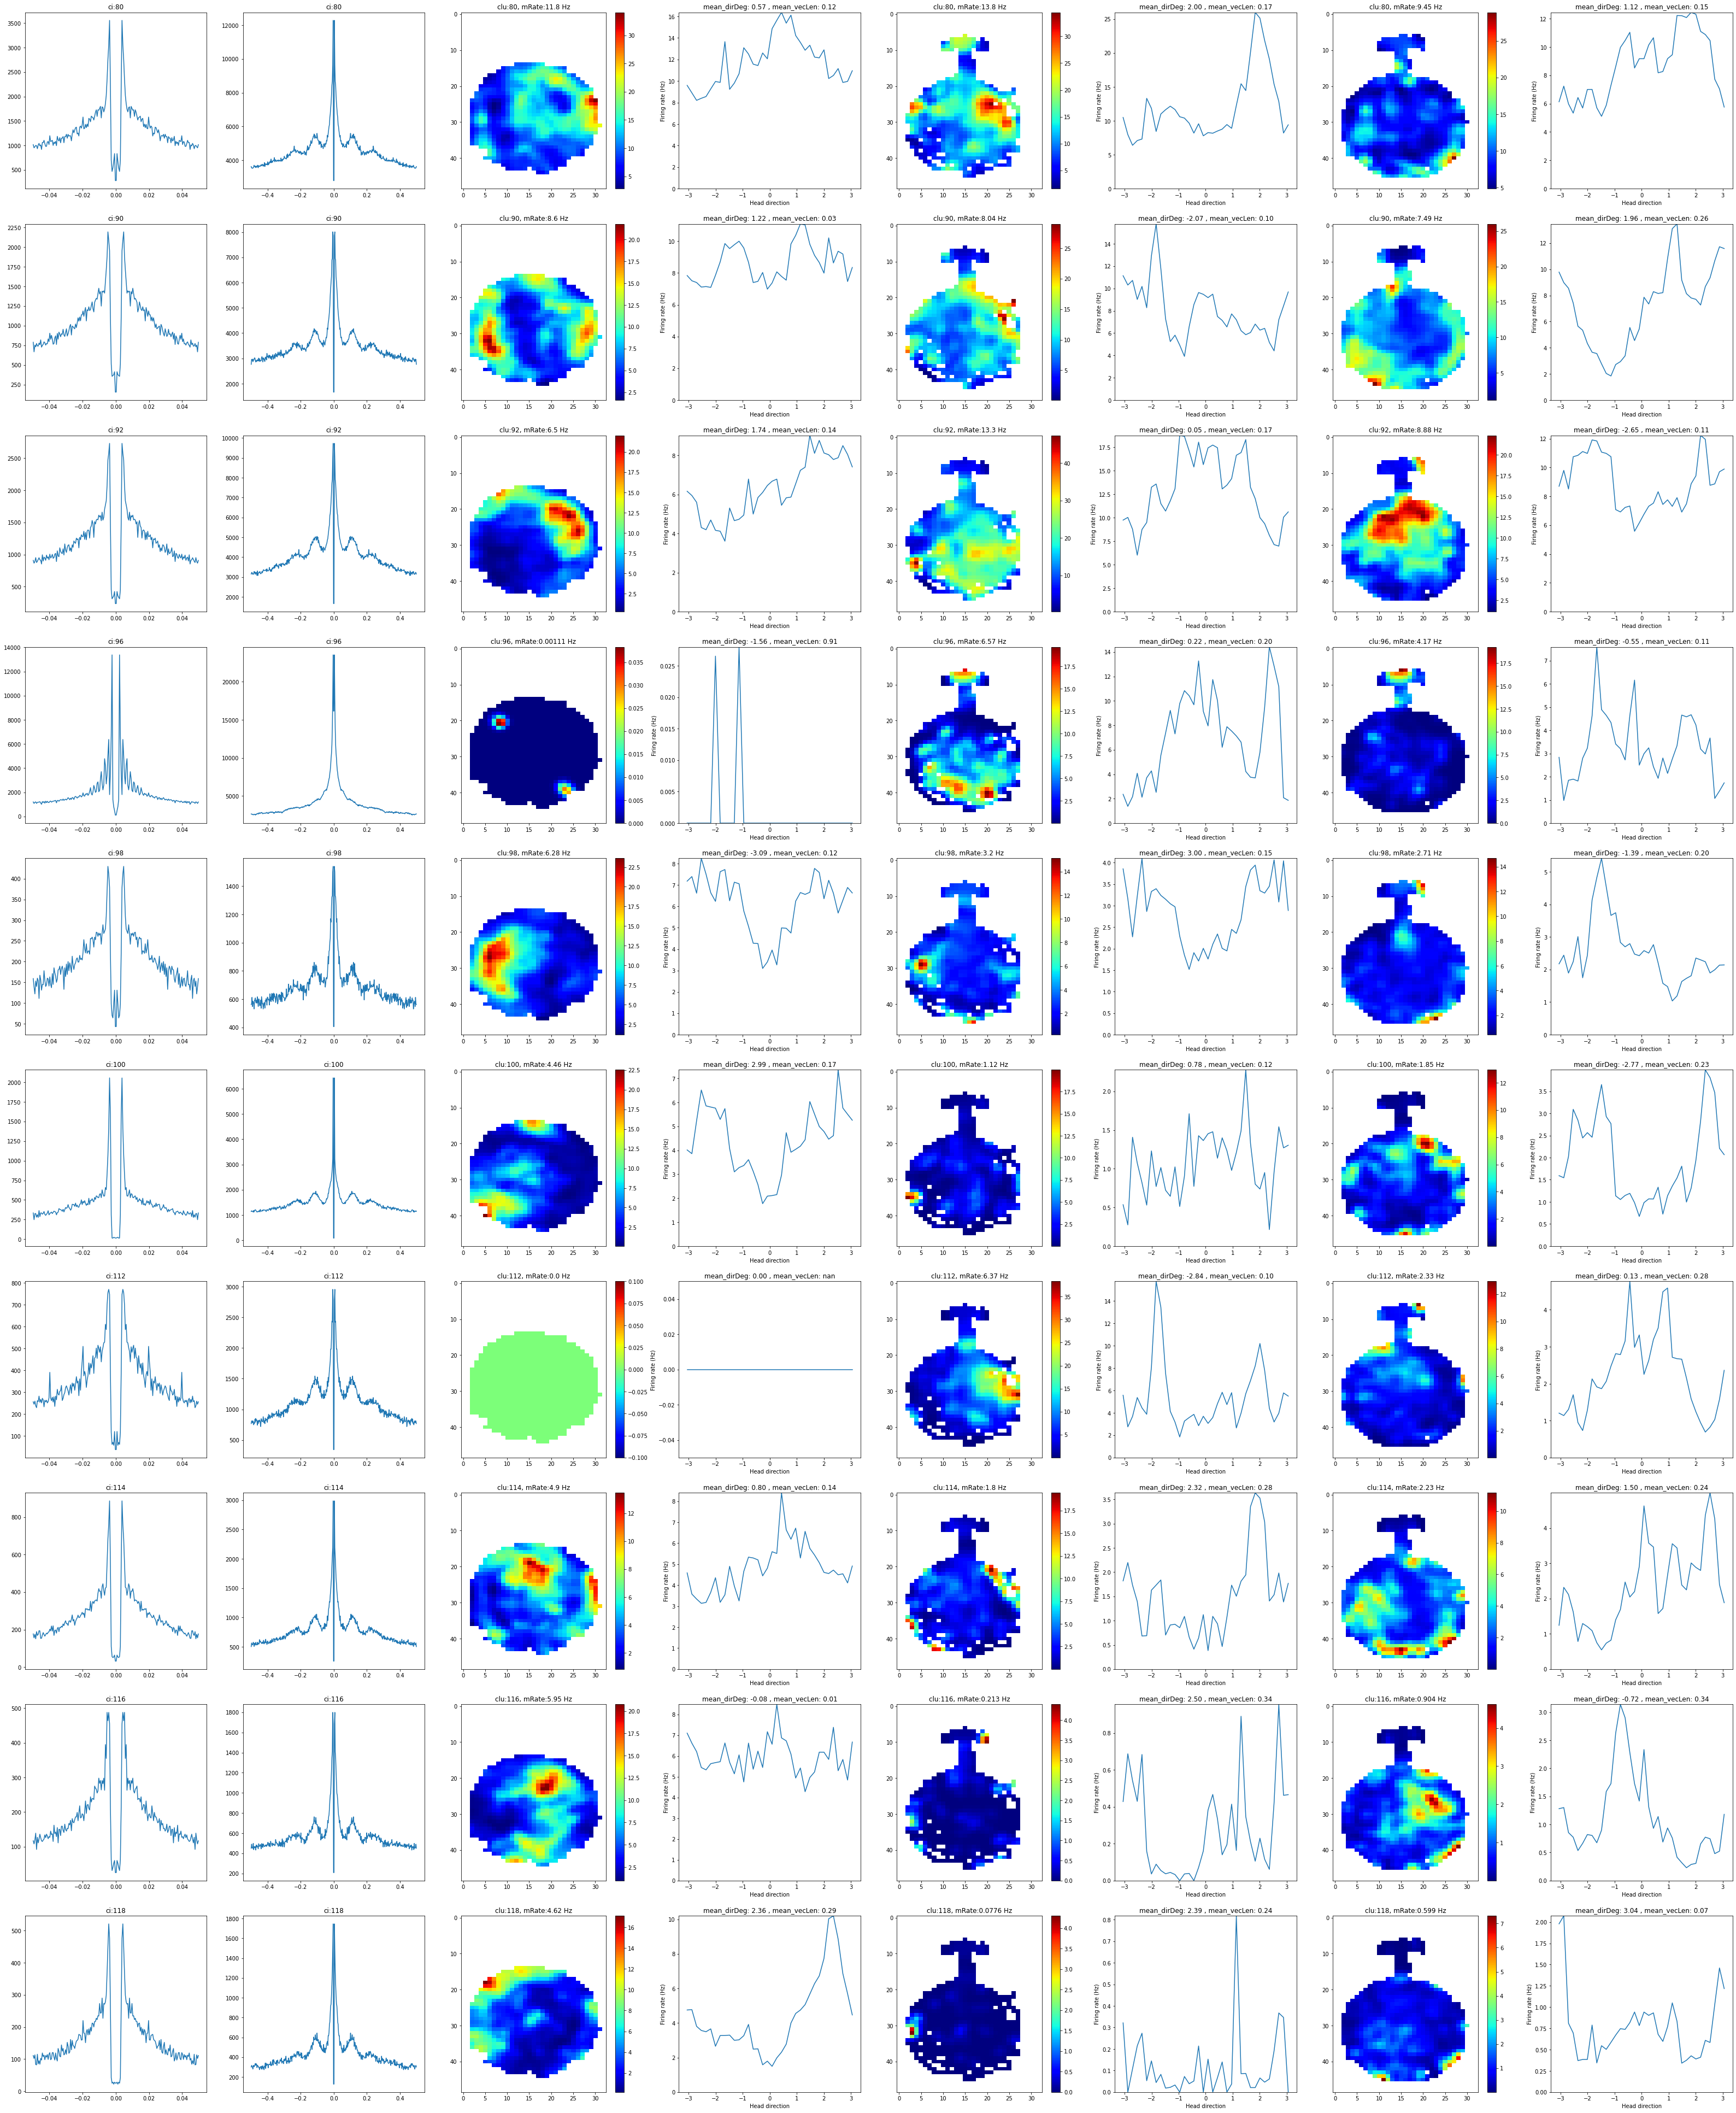

In [60]:
ap= Animal_pose(sSes)
ap.load_pose_from_file()
#nrows=len(sSes.cg.neuron_list)
nrows=10
ncols=8

fig,axs = plt.subplots(nrows,ncols,figsize=(ncols*7,nrows*7))
for i, n in enumerate(tqdm(sSes.cg.neuron_list[:11])):
    axs[i,0].plot(AutoCorr500[0][i,:], AutoCorr500[1][i,:])
    axs[i,0].set_title("ci:{}".format(n.name))
    
    axs[i,1].plot(AutoCorr50[0][i,:], AutoCorr50[1][i,:])
    axs[i,1].set_title("ci:{}".format(n.name))
    
    for j, interv in enumerate(['circ80','light','dark']):
            n.spike_train.unset_intervals()
            ap.unset_intervals()
        
            n.spike_train.set_intervals(ses.intervalDict[interv])
            ap.set_intervals(ses.intervalDict[interv])
        
            im = axs[i,2+j*2].imshow(map_Stack[interv][0][i,:,:].T,cmap='jet', interpolation='nearest', aspect='auto')
            axs[i,2+j*2].set_title("clu:{}, mRate:{:.3} Hz".format(n.name,n.spike_train.mean_firing_rate()))
            fig.colorbar(im,ax=axs[i,2+j*2])
    
            axs[i,3+j*2].plot(hd_Stack[interv][0][1][i],hd_Stack[interv][0][0][i])
            meanDeg=hd_Stack[interv][0][3][i] 
            meanVecLen= hd_Stack[interv][0][2][i]
            axs[i,3+j*2].set_title("mean_dirDeg: {:.2f} , mean_vecLen: {:.2f}".format(meanDeg, meanVecLen))
            axs[i,3+j*2].set_xlabel("Head direction")
            axs[i,3+j*2].set_ylabel("Firing rate (Hz)")
            axs[i,3+j*2].set_ylim(0,np.nanmax(hd_Stack[interv][0][0][i]))
    

fn= sSes.name+ '_hd_summary.pdf'
plt.savefig('/home/kilo/Desktop/'+fn)
fn= sSes.fileBase+ '_hd_summary.pdf'
plt.savefig(fn)
plt.show()

## Get the hd histogram of all sessions 

In [76]:
l=['circ80','circ80_1','circ80_2','light','dark', 'last_rest']
hddict= {}
mapdict={}
for cond in l:
    print(cond)
    hddict[cond]= [getHDinfos(ses,sSes, interName=cond) for ses,sSes in tqdm(zip(myProject.sessionList,sSesList))]
    mapdict[cond]= [getMaps(ses,sSes,interName=cond) for ses,sSes in tqdm(zip(myProject.sessionList,sSesList))]

circ80


0it [00:00, ?it/s]/home/kilo/repo/spikeA/spikeA/Spatial_properties.py:200: RuntimeWarning: invalid value encountered in double_scalars
  self.hd_mean_vector_length = R/sum_histo
44it [00:13,  3.36it/s]
44it [00:12,  3.53it/s]


circ80_1


44it [00:06,  7.21it/s]
44it [00:05,  7.77it/s]


circ80_2


44it [00:06,  7.14it/s]
44it [00:05,  7.70it/s]


light


44it [01:05,  1.50s/it]
44it [01:05,  1.49s/it]


dark


44it [01:00,  1.37s/it]
44it [01:00,  1.36s/it]


last_rest


44it [00:07,  5.64it/s]
44it [00:06,  6.29it/s]


In [77]:
hd_hist_circ80=np.concatenate([mytuple[0] for mytuple in hddict['circ80']])
hd_hist_circ80_1=np.concatenate([mytuple[0] for mytuple in hddict['circ80_1']])
hd_hist_circ80_2=np.concatenate([mytuple[0] for mytuple in hddict['circ80_2']])
hd_hist_light=np.concatenate([mytuple[0] for mytuple in hddict['light']])
hd_hist_dark=np.concatenate([mytuple[0] for mytuple in hddict['dark']])
hd_hist_last_rest=np.concatenate([mytuple[0] for mytuple in hddict['last_rest']])

hd_hist_edge_circ80=np.concatenate([mytuple[1] for mytuple in hddict['circ80']])
hd_hist_edge_circ80_1=np.concatenate([mytuple[1] for mytuple in hddict['circ80_1']])
hd_hist_edge_circ80_2=np.concatenate([mytuple[1] for mytuple in hddict['circ80_2']])
hd_hist_edge_light=np.concatenate([mytuple[1] for mytuple in hddict['light']])
hd_hist_edge_dark=np.concatenate([mytuple[1] for mytuple in hddict['dark']])
hd_hist_edge_last_rest=np.concatenate([mytuple[1] for mytuple in hddict['last_rest']])

hd_mean_vecLen_circ80=np.concatenate([mytuple[2] for mytuple in hddict['circ80']])
hd_mean_vecLen_circ80_1=np.concatenate([mytuple[2] for mytuple in hddict['circ80_1']])
hd_mean_vecLen_circ80_2=np.concatenate([mytuple[2] for mytuple in hddict['circ80_2']])
hd_mean_vecLen_light=np.concatenate([mytuple[2] for mytuple in hddict['light']])
hd_mean_vecLen_dark=np.concatenate([mytuple[2] for mytuple in hddict['dark']])
hd_mean_vecLen_last_rest=np.concatenate([mytuple[2] for mytuple in hddict['last_rest']])

hd_mean_dirDeg_circ80=np.concatenate([mytuple[3] for mytuple in hddict['circ80']])
hd_mean_dirDeg_circ80_1=np.concatenate([mytuple[3] for mytuple in hddict['circ80_1']])
hd_mean_dirDeg_circ80_2=np.concatenate([mytuple[3] for mytuple in hddict['circ80_2']])
hd_mean_dirDeg_light=np.concatenate([mytuple[3] for mytuple in hddict['light']])
hd_mean_dirDeg_dark=np.concatenate([mytuple[3] for mytuple in hddict['dark']])
hd_mean_dirDeg_last_rest=np.concatenate([mytuple[3] for mytuple in hddict['last_rest']])


AutoCorr500 = np.hstack([getAutoCorr(ses,sSes,binSize=0.0005,minTime=-0.05,maxTime=0.05) for sSes in tqdm(sSesList)])
AutoCorr50 = np.hstack([getAutoCorr(ses,sSes,binSize=0.0025,minTime=-0.5,maxTime=0.5) for sSes in tqdm(sSesList)])


100%|██████████| 44/44 [00:10<00:00,  4.01it/s]


## Save these matrices for later use

Since it takes some time to calculate these maps, autocorrelations and firing rate maps, we can save the results.

We will save them as npy files.

In [80]:
print(hd_hist_circ80.shape,hd_hist_light.shape,hd_hist_dark.shape)
print(hd_hist_edge_circ80.shape,hd_hist_edge_light.shape, hd_hist_edge_dark.shape)
print(hd_mean_dirDeg_circ80.shape ,hd_mean_dirDeg_circ80_1.shape , hd_mean_dirDeg_circ80_2.shape, hd_mean_dirDeg_light.shape, hd_mean_dirDeg_dark.shape)
print(AutoCorr500.shape,AutoCorr50.shape)

fb=myProject.dataPath+"/results/"
np.save(fb+"hd_hist_circ80.npy",hd_hist_circ80)
np.save(fb+"hd_hist_circ80_1.npy",hd_hist_circ80_1)
np.save(fb+"hd_hist_circ80_2.npy",hd_hist_circ80_2)
np.save(fb+"hd_hist_light.npy",hd_hist_light)
np.save(fb+"hd_hist_dark.npy",hd_hist_dark)
np.save(fb+"hd_hist_last_rest.npy",hd_hist_last_rest)

np.save(fb+"hd_hist_edge_circ80.npy",hd_hist_edge_circ80)
np.save(fb+"hd_hist_edge_circ80_1.npy",hd_hist_edge_circ80_1)
np.save(fb+"hd_hist_edge_circ80_2.npy",hd_hist_edge_circ80_2)
np.save(fb+"hd_hist_edge_light.npy",hd_hist_edge_light)
np.save(fb+"hd_hist_edge_dark.npy",hd_hist_edge_dark)
np.save(fb+"hd_hist_edge_last_rest.npy",hd_hist_edge_last_rest)

np.save(fb+"hd_mean_vecLen_circ80.npy",hd_mean_vecLen_circ80)
np.save(fb+"hd_mean_vecLen_circ80_1.npy",hd_mean_vecLen_circ80_1)
np.save(fb+"hd_mean_vecLen_circ80_2.npy",hd_mean_vecLen_circ80_2)
np.save(fb+"hd_mean_vecLen_light.npy",hd_mean_vecLen_light)
np.save(fb+"hd_mean_vecLen_dark.npy",hd_mean_vecLen_dark)
np.save(fb+"hd_mean_vecLen_last_rest.npy",hd_mean_vecLen_last_rest)

np.save(fb+"hd_mean_dirDeg_circ80.npy",hd_mean_dirDeg_circ80)
np.save(fb+"hd_mean_dirDeg_circ80_1.npy",hd_mean_dirDeg_circ80_1)
np.save(fb+"hd_mean_dirDeg_circ80_2.npy",hd_mean_dirDeg_circ80_2)
np.save(fb+"hd_mean_dirDeg_light.npy",hd_mean_dirDeg_light)
np.save(fb+"hd_mean_dirDeg_dark.npy",hd_mean_dirDeg_dark)
np.save(fb+"hd_mean_dirDeg_last_rest.npy",hd_mean_dirDeg_last_rest)


np.save(fb+"spikeTimeAutoCorr500.npy",AutoCorr500)
np.save(fb+"spikeTimeAutoCorr50.npy",AutoCorr50)

(1489, 36) (1489, 36) (1489, 36)
(1489, 36) (1489, 36) (1489, 36)
(1489,) (1489,) (1489,) (1489,) (1489,)
(2, 1489, 200) (2, 1489, 400)


In [81]:
type(hd_mean_dirDeg_light)

numpy.ndarray